# 01: Data Pipeline - Download, Preprocessing, and Exploration

This notebook covers the complete data pipeline from download to preprocessed dataset:

1. **Kaggle API Setup** - Configure authentication for dataset download
2. **Download Dataset** - Fetch Genius Song Lyrics dataset (~9GB)
3. **Load & Explore Raw Data** - Examine the original dataset
4. **Preprocessing** - Clean lyrics, remove placeholders, filter genres
5. **Balance Dataset** - Create balanced samples across genres
6. **Save Processed Data** - Export for use in modeling notebooks

**Output:** `data/song_lyrics_balanced.csv` - Ready for model training

## Setup

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Import our modules
from src.data_loader import (
    load_raw_data, 
    preprocess_data, 
    balance_dataset,
    get_dataset_stats,
    is_placeholder,
    clean_lyrics
)
from src.utils import GENRES, RAW_DATA_PATH, BALANCED_DATA_PATH

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Setup complete!")

/home/jovyan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


✓ Setup complete!


## 1. Kaggle API Setup

**First time setup:**
1. Go to https://www.kaggle.com/settings
2. Click "Create New Token" under API section
3. Save `kaggle.json` to project root
4. Run the cell below

**Note:** If you already have `data/song_lyrics.csv`, skip to Section 2.

In [2]:
import os
import json
from pathlib import Path

# Check for kaggle.json in project root
kaggle_json_path = project_root / 'kaggle.json'

if kaggle_json_path.exists():
    # Set up Kaggle credentials
    os.environ['KAGGLE_CONFIG_DIR'] = str(project_root)
    
    # Verify credentials
    with open(kaggle_json_path, 'r') as f:
        creds = json.load(f)
        print(f"✓ Kaggle credentials found for user: {creds.get('username', 'unknown')}")
    
    # Set permissions (required on Unix systems)
    os.chmod(kaggle_json_path, 0o600)
    print("✓ Permissions set correctly")
else:
    print("⚠️  kaggle.json not found!")
    print("   Please download from https://www.kaggle.com/settings and place in project root")
    print(f"   Expected location: {kaggle_json_path}")

✓ Kaggle credentials found for user: onatakca
✓ Permissions set correctly


## 2. Download Dataset from Kaggle

**Dataset:** [Genius Song Lyrics with Language Information](https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information)

- **Size:** ~9GB compressed, ~15GB uncompressed CSV
- **Content:** 5.1M song lyrics across 6 genres
- **Download time:** 5-15 minutes depending on connection

**Skip this section if data already exists.**

In [3]:
# Check if data already exists
if RAW_DATA_PATH.exists():
    file_size_gb = RAW_DATA_PATH.stat().st_size / (1024**3)
    print(f"✓ Dataset already exists: {RAW_DATA_PATH}")
    print(f"  Size: {file_size_gb:.2f} GB")
else:
    print("Dataset not found. Downloading from Kaggle...")
    print("This will take 5-15 minutes depending on your connection.")
    
    # Create data directory if it doesn't exist
    RAW_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    # Download using Kaggle API
    import kaggle
    
    dataset_name = 'carlosgdcj/genius-song-lyrics-with-language-information'
    
    try:
        kaggle.api.dataset_download_files(
            dataset_name,
            path=RAW_DATA_PATH.parent,
            unzip=True
        )
        print(f"✓ Download complete: {RAW_DATA_PATH}")
    except Exception as e:
        print(f"❌ Download failed: {e}")
        print("   Please download manually from Kaggle and place in data/ directory")

Dataset not found. Downloading from Kaggle...
This will take 5-15 minutes depending on your connection.
Dataset URL: https://www.kaggle.com/datasets/carlosgdcj/genius-song-lyrics-with-language-information
✓ Download complete: /home/jovyan/Desktop/NLP/Project/data/song_lyrics.csv


## 3. Load & Explore Raw Data

Let's examine the original dataset to understand what we're working with.

In [4]:
# Load raw data
df_raw = load_raw_data()

print(f"\nDataset shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1e9:.2f} GB")

Loading data from /home/jovyan/Desktop/NLP/Project/data/song_lyrics.csv...
✅ Loaded 5,134,856 songs
   Columns: ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'id', 'language_cld3', 'language_ft', 'language']

Dataset shape: (5134856, 11)
Memory usage: 15.48 GB


In [5]:
# Display first few rows
df_raw.head()

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


In [6]:
# Column information
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5134856 entries, 0 to 5134855
Data columns (total 11 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   title          object
 1   tag            object
 2   artist         object
 3   year           int64 
 4   views          int64 
 5   features       object
 6   lyrics         object
 7   id             int64 
 8   language_cld3  object
 9   language_ft    object
 10  language       object
dtypes: int64(3), object(8)
memory usage: 430.9+ MB


### Genre Distribution (Original Dataset)

In [7]:
# Genre counts
genre_counts = df_raw['tag'].value_counts()
print("Genre distribution:\n")
print(genre_counts)
print(f"\nTotal genres: {len(genre_counts)}")

Genre distribution:

tag
pop        2138587
rap        1724816
rock        793220
rb          196462
misc        181455
country     100316
Name: count, dtype: int64

Total genres: 6


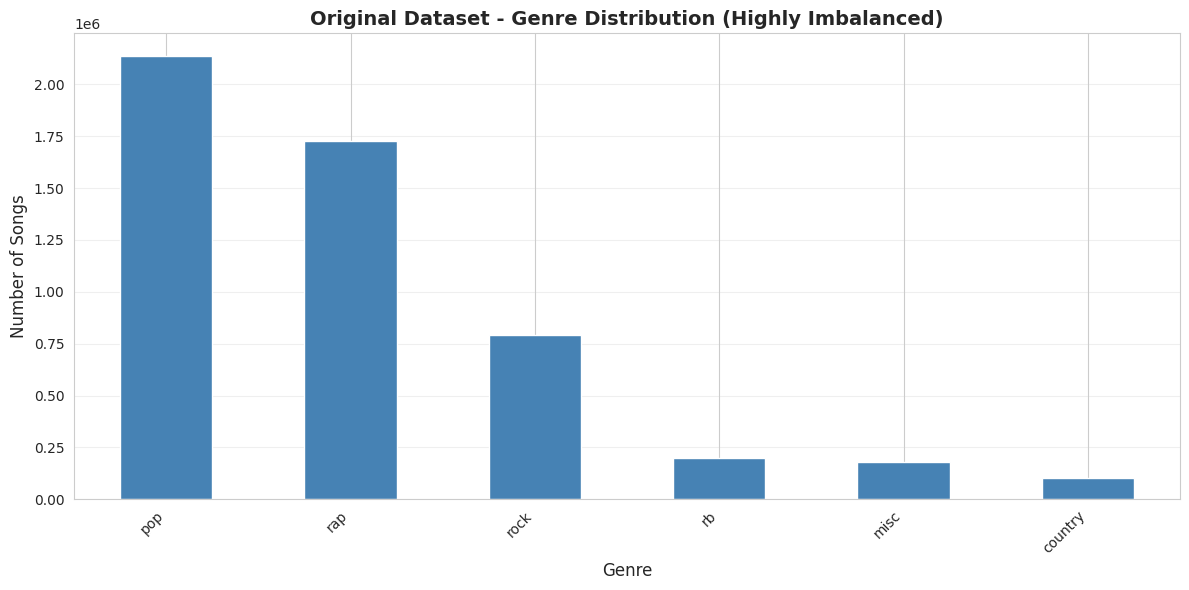


📊 Imbalance ratio: 21.3x


In [8]:
# Visualize genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='steelblue')
plt.title('Original Dataset - Genre Distribution (Highly Imbalanced)', fontsize=14, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Imbalance ratio: {genre_counts.max() / genre_counts.min():.1f}x")

### Language Distribution

The dataset contains multilingual lyrics. Let's see the distribution.

Top 10 languages:

language
en    3374198
es     275432
fr     189436
pt     167947
ru     166044
de     160150
it     118775
pl      83862
tr      44692
ja      42637
Name: count, dtype: int64


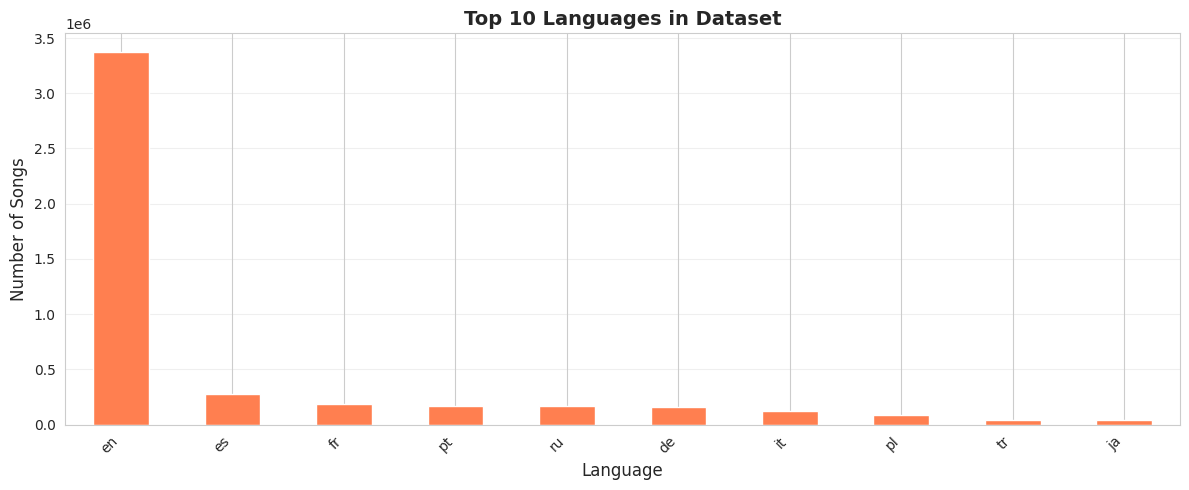

In [9]:
# Language distribution
if 'language' in df_raw.columns:
    lang_counts = df_raw['language'].value_counts().head(10)
    print("Top 10 languages:\n")
    print(lang_counts)
    
    plt.figure(figsize=(12, 5))
    lang_counts.plot(kind='bar', color='coral')
    plt.title('Top 10 Languages in Dataset', fontsize=14, fontweight='bold')
    plt.xlabel('Language', fontsize=12)
    plt.ylabel('Number of Songs', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No language column found")

### Lyrics Statistics

In [10]:
# Sample some lyrics
print("Sample lyrics from different genres:\n")
for genre in df_raw['tag'].unique()[:3]:
    sample = df_raw[df_raw['tag'] == genre].iloc[0]
    lyrics_preview = str(sample['lyrics'])[:200]
    print(f"\n{'='*80}")
    print(f"Genre: {genre.upper()}")
    print(f"Song: {sample.get('title', 'Unknown')} - {sample.get('artist', 'Unknown')}")
    print(f"{'='*80}")
    print(lyrics_preview + "...")

Sample lyrics from different genres:


Genre: RAP
Song: Killa Cam - Cam'ron
[Chorus: Opera Steve & Cam'ron]
Killa Cam, Killa Cam, Cam
Killa Cam, Killa Cam
Killa Cam, Cam
Killa Cam, Killa Cam, Cam
Killa Killa Killa Cam
Killa Cam, Cam, Killa (Killa!)
Killa Cam, Killa Cam, Cam (...

Genre: RB
Song: Yeah - Usher
[Produced by Lil Jon]

[Intro: Usher & Lil Jon]
Peace up, A-Town down
Yeah, yeah! Okay, okay!
Usher (Usher, Usher, Usher, Usher)
Lil Jon
Let's go!
Yeah, yeah, yeah, yeah, yeah, yeah!
Yeah, yeah, yeah,...

Genre: ROCK
Song: Subterranean Homesick Blues - Bob Dylan
[Verse 1]
Johnny's in the basement, mixin' up the medicine
I'm on the pavement, thinkin' about the government
The man in a trench coat, badge out, laid off
Says he's got a bad cough, wants to get it p...


### Check for Placeholder Lyrics

Many songs have placeholder text instead of actual lyrics (e.g., "Instrumental", "Lyrics will be added soon").

In [11]:
# Count placeholder lyrics
placeholder_mask = df_raw['lyrics'].apply(is_placeholder)
n_placeholders = placeholder_mask.sum()
pct_placeholders = (n_placeholders / len(df_raw)) * 100

print(f"Placeholder lyrics: {n_placeholders:,} ({pct_placeholders:.1f}%)")
print(f"Real lyrics: {(~placeholder_mask).sum():,} ({100-pct_placeholders:.1f}%)")

# Show examples of placeholders
print("\nExample placeholder lyrics:")
for i, lyrics in enumerate(df_raw[placeholder_mask]['lyrics'].head(5)):
    print(f"  {i+1}. {str(lyrics)[:100]}")

Placeholder lyrics: 244 (0.0%)
Real lyrics: 5,134,612 (100.0%)

Example placeholder lyrics:
  1. Tell us that you would like to have the lyrics of this song. Then we'll make it our highest priority
  2. Tell us that you would like to have the lyrics of this song. Then we'll make it our highest priority
  3. Tell us that you would like to have the lyrics of this song. Then we'll make it our highest priority
  4. Tell us that you would like to have the lyrics of this song. Then we'll make it our highest priority
  5. Tell us that you would like to have the lyrics of this song. Then we'll make it our highest priority


## 4. Preprocessing

Clean the data by:
1. Removing placeholder lyrics
2. Filtering to valid genres (exclude 'misc')
3. Cleaning text (lowercase, remove markers, normalize whitespace)

In [12]:
# Preprocess the data
df_cleaned = preprocess_data(df_raw, remove_placeholders=True)

print(f"\n{'='*80}")
print(f"Original dataset: {len(df_raw):,} songs")
print(f"Cleaned dataset: {len(df_cleaned):,} songs")
print(f"Removed: {len(df_raw) - len(df_cleaned):,} songs ({(1 - len(df_cleaned)/len(df_raw))*100:.1f}%)")
print(f"{'='*80}")


Preprocessing data...
  Filtered to 5 genres: 4,953,401 songs
  Removed 181,696 placeholder lyrics
  Final dataset: 4,953,160 songs

Original dataset: 5,134,856 songs
Cleaned dataset: 4,953,160 songs
Removed: 181,696 songs (3.5%)


### Cleaned Genre Distribution

Genre distribution after cleaning:

tag
pop        2138352
rap        1724811
rock        793219
rb          196462
country     100316
Name: count, dtype: int64


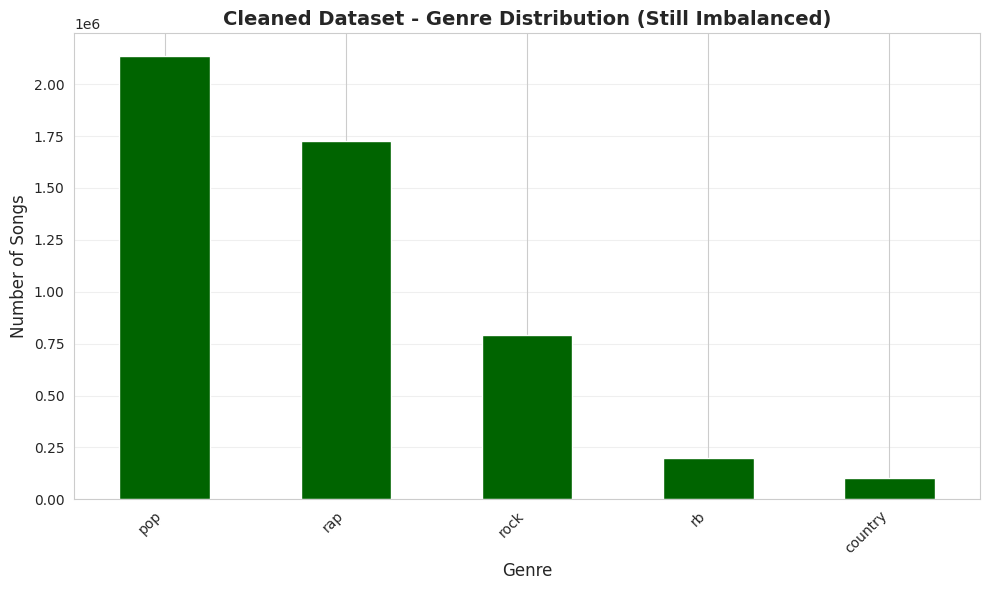

In [13]:
# Genre distribution after cleaning
cleaned_genre_counts = df_cleaned['tag'].value_counts()
print("Genre distribution after cleaning:\n")
print(cleaned_genre_counts)

# Visualize
plt.figure(figsize=(10, 6))
cleaned_genre_counts.plot(kind='bar', color='darkgreen')
plt.title('Cleaned Dataset - Genre Distribution (Still Imbalanced)', fontsize=14, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Text Statistics After Cleaning

In [14]:
# Get detailed statistics per genre
stats_df = get_dataset_stats(df_cleaned)
print("\nStatistics by genre:\n")
print(stats_df.to_string(index=False))


Statistics by genre:

  genre   count  avg_words  median_words   avg_chars  median_chars
country  100316 222.235705         210.0 1118.904422        1050.0
    pop 2138352 220.501981         198.0 1129.371866        1012.0
    rap 1724811 411.203680         388.0 2143.290748        2025.0
     rb  196462 298.116547         279.0 1484.431539        1389.0
   rock  793219 194.687528         180.0 1006.796383         932.0


AttributeError: Can only use .cat accessor with a 'category' dtype

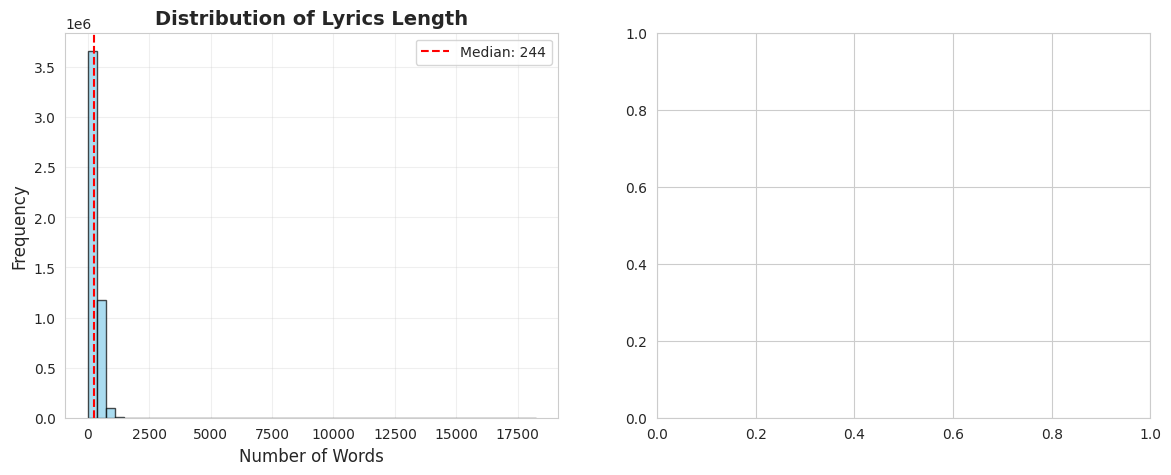

In [15]:
# Visualize word count distribution
df_cleaned['word_count'] = df_cleaned['lyrics_cleaned'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df_cleaned['word_count'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Words', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Lyrics Length', fontsize=14, fontweight='bold')
axes[0].axvline(df_cleaned['word_count'].median(), color='red', linestyle='--', label=f'Median: {df_cleaned["word_count"].median():.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by genre
genre_order = cleaned_genre_counts.index
df_cleaned['tag'].cat.set_categories(genre_order, inplace=True)
sns.boxplot(data=df_cleaned, x='tag', y='word_count', ax=axes[1], palette='Set2')
axes[1].set_xlabel('Genre', fontsize=12)
axes[1].set_ylabel('Number of Words', fontsize=12)
axes[1].set_title('Lyrics Length by Genre', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOverall statistics:")
print(f"  Mean words per song: {df_cleaned['word_count'].mean():.0f}")
print(f"  Median words per song: {df_cleaned['word_count'].median():.0f}")
print(f"  Min: {df_cleaned['word_count'].min()}, Max: {df_cleaned['word_count'].max()}")

### Example of Cleaned Lyrics

In [ ]:
# Show before/after cleaning
sample_idx = 100
original_text = df_raw.iloc[sample_idx]['lyrics']
cleaned_text = clean_lyrics(original_text)

print("BEFORE CLEANING:")
print("="*80)
print(str(original_text)[:300])
print("\n" + "="*80)
print("\nAFTER CLEANING:")
print("="*80)
print(cleaned_text[:300])

## 5. Balance Dataset

Create a balanced dataset by sampling equal numbers from each genre.

**Why balance?**
- Machine learning models perform poorly on imbalanced data
- Pop and rap dominate (2.1M and 1.7M songs respectively)
- Other genres would be underrepresented

**Strategy:** Sample N songs per genre where N is configurable

In [16]:
# Create balanced dataset
# You can change this number based on your needs and computational resources
SAMPLES_PER_GENRE = 100000  # 100K per genre = 500K total songs

df_balanced = balance_dataset(df_cleaned, samples_per_genre=SAMPLES_PER_GENRE)


Balancing dataset to 100,000 samples per genre...
  country: 100,000
  pop: 100,000
  rap: 100,000
  rb: 100,000
  rock: 100,000

✅ Balanced dataset: 500,000 songs



Balanced genre distribution:

tag
pop        100000
rock       100000
rap        100000
country    100000
rb         100000
Name: count, dtype: int64


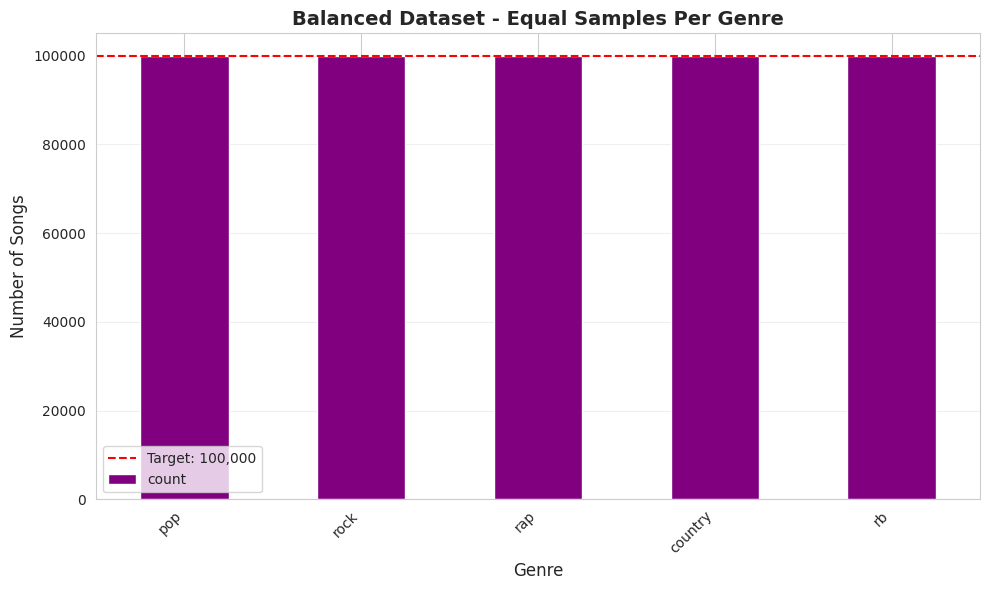

In [17]:
# Verify balance
balanced_genre_counts = df_balanced['tag'].value_counts()
print("\nBalanced genre distribution:\n")
print(balanced_genre_counts)

# Visualize
plt.figure(figsize=(10, 6))
balanced_genre_counts.plot(kind='bar', color='purple')
plt.title('Balanced Dataset - Equal Samples Per Genre', fontsize=14, fontweight='bold')
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.axhline(y=SAMPLES_PER_GENRE, color='red', linestyle='--', label=f'Target: {SAMPLES_PER_GENRE:,}')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### Vocabulary Analysis

Let's examine the most common words per genre to get intuition about what makes each genre distinctive.

In [18]:
from collections import Counter
import re

def get_top_words(texts, n=20, exclude_common=True):
    """Get top N most common words from texts."""
    # Common stopwords to exclude
    stopwords = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
                 'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'were', 'be',
                 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will',
                 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'i', 'you',
                 'he', 'she', 'it', 'we', 'they', 'them', 'this', 'that', 'these', 'those',
                 'my', 'your', 'me', 'im', 'youre', 'dont', 'aint'} if exclude_common else set()
    
    all_words = []
    for text in texts:
        words = str(text).lower().split()
        # Filter out stopwords and very short words
        words = [w for w in words if len(w) > 2 and w not in stopwords]
        all_words.extend(words)
    
    return Counter(all_words).most_common(n)

# Get top words for each genre
print("Top 15 distinctive words per genre:\n")
for genre in GENRES:
    genre_lyrics = df_balanced[df_balanced['tag'] == genre]['lyrics_cleaned']
    top_words = get_top_words(genre_lyrics, n=15)
    
    print(f"\n{genre.upper()}:")
    words_str = ', '.join([f"{word}({count:,})" for word, count in top_words])
    print(f"  {words_str}")

Top 15 distinctive words per genre:


COUNTRY:
  all(141,599), i'm(136,065), just(115,749), [verse(107,160), when(106,676), like(105,883), love(105,365), don't(99,127), know(92,555), it's(86,416), got(80,983), down(78,068), what(70,459), out(69,169), one(65,885)

POP:
  i'm(116,822), all(116,772), que(106,897), know(87,730), don't(87,400), love(86,952), like(83,415), just(80,998), when(70,901), it's(70,278), what(66,232), now(56,443), got(52,434), get(50,923), you're(50,598)

RAP:
  i'm(253,447), like(235,561), got(156,547), all(155,148), que(136,219), get(134,728), just(134,561), know(132,447), don't(121,801), when(97,391), out(89,084), what(88,974), ain't(87,072), ich(84,302), yeah(82,046)

RB:
  i'm(204,481), know(202,640), love(193,484), all(180,198), just(168,352), don't(165,507), like(163,543), got(128,685), what(119,890), when(116,862), yeah(115,832), baby(113,237), get(108,250), wanna(98,469), [verse(96,744)

ROCK:
  all(130,760), i'm(108,668), just(78,506), don't(78,376), know

## 6. Save Preprocessed Data

Save the balanced dataset for use in subsequent modeling notebooks.

In [19]:
# Save to CSV
print(f"Saving balanced dataset to {BALANCED_DATA_PATH}...")
df_balanced.to_csv(BALANCED_DATA_PATH, index=False)

file_size_mb = BALANCED_DATA_PATH.stat().st_size / (1024**2)
print(f"\n✓ Saved successfully!")
print(f"  File: {BALANCED_DATA_PATH}")
print(f"  Size: {file_size_mb:.1f} MB")
print(f"  Rows: {len(df_balanced):,}")
print(f"  Columns: {len(df_balanced.columns)}")

Saving balanced dataset to /home/jovyan/Desktop/NLP/Project/data/song_lyrics_balanced.csv...

✓ Saved successfully!
  File: /home/jovyan/Desktop/NLP/Project/data/song_lyrics_balanced.csv
  Size: 1417.5 MB
  Rows: 500,000
  Columns: 13


## Summary

**Data Pipeline Complete!**

We've successfully:
1. ✓ Downloaded the Genius Song Lyrics dataset (~9GB)
2. ✓ Loaded and explored the raw data (5.1M songs)
3. ✓ Preprocessed and cleaned lyrics
4. ✓ Removed placeholder lyrics
5. ✓ Created a balanced dataset across 5 genres
6. ✓ Saved processed data for modeling

**Output File:** `data/song_lyrics_balanced.csv`

**Next Steps:**
- **Notebook 02:** Train baseline models (TF-IDF + classical ML)
- **Notebook 03:** Train advanced models (Word2Vec, BERT)
- **Notebook 04:** Compare and evaluate all models

In [20]:
# Final summary statistics
print("\n" + "="*80)
print("FINAL DATASET SUMMARY")
print("="*80)
print(f"Total songs: {len(df_balanced):,}")
print(f"Genres: {len(GENRES)} - {', '.join(GENRES)}")
print(f"Samples per genre: {SAMPLES_PER_GENRE:,}")
print(f"Average words per song: {df_balanced['lyrics_cleaned'].str.split().str.len().mean():.0f}")
print(f"Total vocabulary size: {len(set(' '.join(df_balanced['lyrics_cleaned']).split())):,} unique words")
print(f"\nReady for model training! 🚀")
print("="*80)


FINAL DATASET SUMMARY
Total songs: 500,000
Genres: 5 - country, pop, rap, rb, rock
Samples per genre: 100,000
Average words per song: 269
Total vocabulary size: 2,971,874 unique words

Ready for model training! 🚀
